In [53]:
%matplotlib inline
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [74]:
df = pd.read_csv("count.txt", sep=" ")
cnt = df.groupby('count').count().reset_index()
cnt['locus']

0    20
1    23
2    43
3    20
4    10
5     2
Name: locus, dtype: int64

In [70]:
from seaborn.categorical import _CategoricalPlotter, remove_na
import matplotlib as mpl

class _CategoricalStatPlotter(_CategoricalPlotter):

    @property
    def nested_width(self):
        """A float with the width of plot elements when hue nesting is used."""
        return self.width / len(self.hue_names)

    def estimate_statistic(self, estimator, ci, n_boot):

        if self.hue_names is None:
            statistic = []
            confint = []
        else:
            statistic = [[] for _ in self.plot_data]
            confint = [[] for _ in self.plot_data]

        for i, group_data in enumerate(self.plot_data):
            # Option 1: we have a single layer of grouping
            # --------------------------------------------

            if self.plot_hues is None:

                if self.plot_units is None:
                    stat_data = remove_na(group_data)
                    unit_data = None
                else:
                    unit_data = self.plot_units[i]
                    have = pd.notnull(np.c_[group_data, unit_data]).all(axis=1)
                    stat_data = group_data[have]
                    unit_data = unit_data[have]

                # Estimate a statistic from the vector of data
                if not stat_data.size:
                    statistic.append(np.nan)
                else:
                    statistic.append(estimator(stat_data, len(np.concatenate(self.plot_data))))

                # Get a confidence interval for this estimate
                if ci is not None:

                    if stat_data.size < 2:
                        confint.append([np.nan, np.nan])
                        continue

                    boots = bootstrap(stat_data, func=estimator,
                                      n_boot=n_boot,
                                      units=unit_data)
                    confint.append(utils.ci(boots, ci))

            # Option 2: we are grouping by a hue layer
            # ----------------------------------------

            else:
                for j, hue_level in enumerate(self.hue_names):
                    if not self.plot_hues[i].size:
                        statistic[i].append(np.nan)
                        if ci is not None:
                            confint[i].append((np.nan, np.nan))
                        continue

                    hue_mask = self.plot_hues[i] == hue_level
                    group_total_n = (np.concatenate(self.plot_hues) == hue_level).sum()
                    if self.plot_units is None:
                        stat_data = remove_na(group_data[hue_mask])
                        unit_data = None
                    else:
                        group_units = self.plot_units[i]
                        have = pd.notnull(
                            np.c_[group_data, group_units]
                            ).all(axis=1)
                        stat_data = group_data[hue_mask & have]
                        unit_data = group_units[hue_mask & have]

                    # Estimate a statistic from the vector of data
                    if not stat_data.size:
                        statistic[i].append(np.nan)
                    else:
                        statistic[i].append(estimator(stat_data, group_total_n))

                    # Get a confidence interval for this estimate
                    if ci is not None:

                        if stat_data.size < 2:
                            confint[i].append([np.nan, np.nan])
                            continue

                        boots = bootstrap(stat_data, func=estimator,
                                          n_boot=n_boot,
                                          units=unit_data)
                        confint[i].append(utils.ci(boots, ci))

        # Save the resulting values for plotting
        self.statistic = np.array(statistic)
        self.confint = np.array(confint)

        # Rename the value label to reflect the estimation
        if self.value_label is not None:
            self.value_label = "{}({})".format(estimator.__name__,
                                               self.value_label)

    def draw_confints(self, ax, at_group, confint, colors,
                      errwidth=None, capsize=None, **kws):

        if errwidth is not None:
            kws.setdefault("lw", errwidth)
        else:
            kws.setdefault("lw", mpl.rcParams["lines.linewidth"] * 1.8)

        for at, (ci_low, ci_high), color in zip(at_group,
                                                confint,
                                                colors):
            if self.orient == "v":
                ax.plot([at, at], [ci_low, ci_high], color=color, **kws)
                if capsize is not None:
                    ax.plot([at - capsize / 2, at + capsize / 2],
                            [ci_low, ci_low], color=color, **kws)
                    ax.plot([at - capsize / 2, at + capsize / 2],
                            [ci_high, ci_high], color=color, **kws)
            else:
                ax.plot([ci_low, ci_high], [at, at], color=color, **kws)
                if capsize is not None:
                    ax.plot([ci_low, ci_low],
                            [at - capsize / 2, at + capsize / 2],
                            color=color, **kws)
                    ax.plot([ci_high, ci_high],
                            [at - capsize / 2, at + capsize / 2],
                            color=color, **kws)

class _BarPlotter(_CategoricalStatPlotter):
    """Show point estimates and confidence intervals with bars."""

    def __init__(self, x, y, hue, data, order, hue_order,
                 estimator, ci, n_boot, units,
                 orient, color, palette, saturation, errcolor, errwidth=None,
                 capsize=None):
        """Initialize the plotter."""
        self.establish_variables(x, y, hue, data, orient,
                                 order, hue_order, units)
        self.establish_colors(color, palette, saturation)
        self.estimate_statistic(estimator, ci, n_boot)

        self.errcolor = errcolor
        self.errwidth = errwidth
        self.capsize = capsize

    def draw_bars(self, ax, kws):
        """Draw the bars onto `ax`."""
        # Get the right matplotlib function depending on the orientation
        barfunc = ax.bar if self.orient == "v" else ax.barh
        barpos = np.arange(len(self.statistic))

        if self.plot_hues is None:

            # Draw the bars
            barfunc(barpos, self.statistic, self.width,
                    color=self.colors, align="center", **kws)

            # Draw the confidence intervals
            errcolors = [self.errcolor] * len(barpos)
            self.draw_confints(ax,
                               barpos,
                               self.confint,
                               errcolors,
                               self.errwidth,
                               self.capsize)

        else:

            for j, hue_level in enumerate(self.hue_names):

                # Draw the bars
                offpos = barpos + self.hue_offsets[j]
                barfunc(offpos, self.statistic[:, j], self.nested_width,
                        color=self.colors[j], align="center",
                        label=hue_level, **kws)

                # Draw the confidence intervals
                if self.confint.size:
                    confint = self.confint[:, j]
                    errcolors = [self.errcolor] * len(offpos)
                    self.draw_confints(ax,
                                       offpos,
                                       confint,
                                       errcolors,
                                       self.errwidth,
                                       self.capsize)

    def plot(self, ax, bar_kws):
        """Make the plot."""
        self.draw_bars(ax, bar_kws)
        self.annotate_axes(ax)
        if self.orient == "h":
            ax.invert_yaxis()

def percentageplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
              orient=None, color=None, palette=None, saturation=.75,
              ax=None, **kwargs):

    # Estimator calculates required statistic (proportion)        
    estimator = lambda x, y: (float(len(x))/y)*100 
    ci = None
    n_boot = 0
    units = None
    errcolor = None

    if x is None and y is not None:
        orient = "h"
        x = y
    elif y is None and x is not None:
        orient = "v"
        y = x
    elif x is not None and y is not None:
        raise TypeError("Cannot pass values for both `x` and `y`")
    else:
        raise TypeError("Must pass values for either `x` or `y`")

    plotter = _BarPlotter(x, y, hue, data, order, hue_order,
                          estimator, ci, n_boot, units,
                          orient, color, palette, saturation,
                          errcolor)

    plotter.value_label = "Percentage"

    if ax is None:
        ax = plt.gca()

    plotter.plot(ax, kwargs)
    return ax

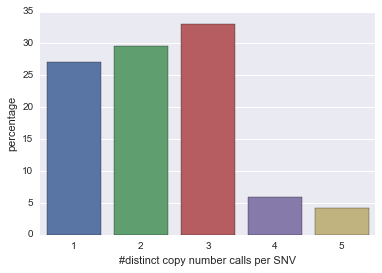

In [71]:
ax = percentageplot(df['count'])
ax.set_xlabel('#distinct copy number calls per SNV')
ax.set_ylabel('percentage')
plt.savefig("A22_CNAs.pdf")

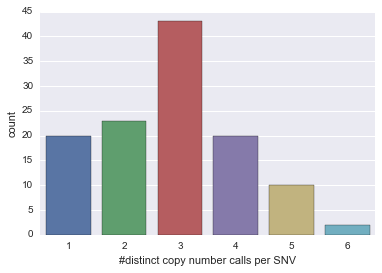

In [78]:
ax = sns.countplot(df['count'])
ax.set_xlabel('#distinct copy number calls per SNV')
ax.set_ylabel('count')
plt.savefig("A22_CNAs.pdf")

([<matplotlib.axis.XTick at 0x11c5ba6d0>,
 <a list of 4 Text xticklabel objects>)

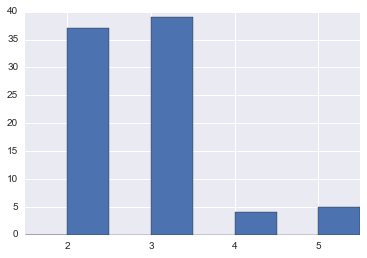

In [26]:
matplotlib.pyplot.hist(df['count'], bins=np.linspace(1.5, 5.5, 9))
matplotlib.pyplot.xticks([2,3,4,5])